# PCA applied to health data
### from Coronary Risk Factor Study by Rossouw et al. (1983)
#### Data available on https://web.stanford.edu/~hastie/ElemStatLearn/ "South African Heart Disease"
The data is about a study on coronary heart disease (CHD) from Rossouw et al. (1983) and Rossouw et al. (1993). They collected the data as part of their Coronary Risk Factor Study (CORIS). It includes health measures, such as blood pressure, cholesterol or smoking. Three South-African com- munities took part in the study and were surveyed by doctors twice, before and after a four year intervention period. The main goal was to find out how effective a mass-media intervention was. As it is an experimental setup, the communities were split up in two treatment and one control group. 1 The main outcome is if CHD is present or not. This is a binary outcome, which is reported after examination.

In [72]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set(style='white')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Plotting preferences
context = ['paper', 'talk', 'poster']
sns.set(style="white")
sns.set_context(context[1])

## Load data inspect and prepare

In [123]:
#load data
path = 'C://Users//Philipp//GDrive//VWL//ML_Intro//Projects//1//data//'
df = pd.read_excel(path+'rawdata_heartdisease.xlsx')

### Data Preparation
#convert string famhist to numeric dummy 
df['famhist'] = pd.get_dummies(df.famhist, columns=["famhist"]).iloc[:,-1]
df.famhist.value_counts()

#Inspect (all numeric vars)
df.describe().round().loc[['count', 'mean', 'std', 'min', 'max']]

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
count,462.0,462.0,462.0,462.0,462.0,462.0,462.0,462.0,462.0,462.0
mean,138.0,4.0,5.0,25.0,0.0,53.0,26.0,17.0,43.0,0.0
std,20.0,5.0,2.0,8.0,0.0,10.0,4.0,24.0,15.0,0.0
min,101.0,0.0,1.0,7.0,0.0,13.0,15.0,0.0,15.0,0.0
max,218.0,31.0,15.0,42.0,1.0,78.0,47.0,147.0,64.0,1.0


In [124]:
# Assign outcome diagnosis of coronary heart disease (chd) to y and covariates to X
y = df["chd"]
X = df.loc[:,df.columns != "chd"]

In [128]:
#standardize
y_std = (y - y.mean()) / y.std()
X_std = (X - X.mean()) / X.std()

## Inspect Distributions
### Using Boxplots and Histograms

C:\Users\Philipp\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


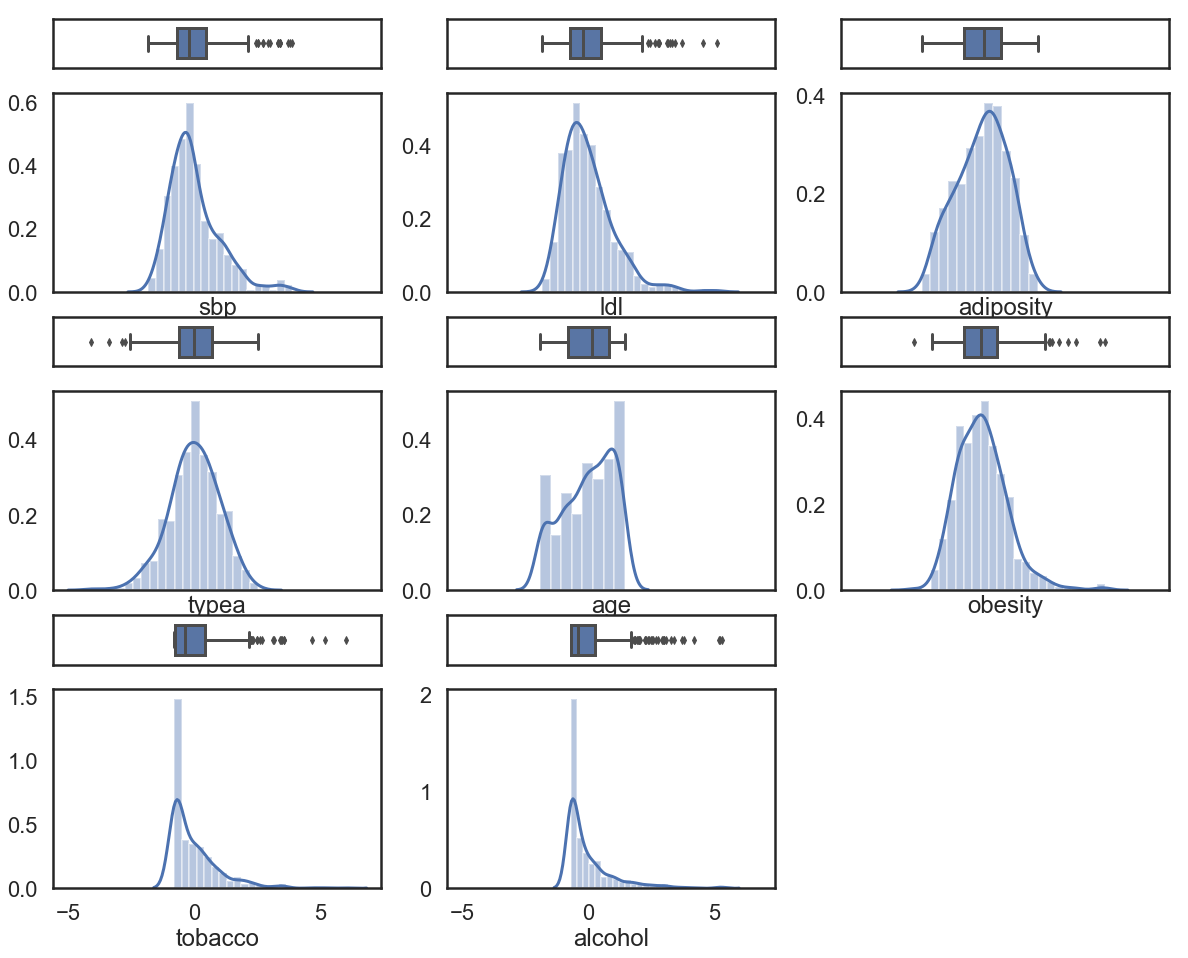

In [127]:
sns.set_context(context[2]) #set seaborn style
x_cols = ['sbp','ldl','adiposity','typea','age','obesity', 'tobacco', 'alcohol'] 

f, axes = plt.subplots(6, 3, figsize=(20, 16), gridspec_kw={"height_ratios": (.2, .8,.2, .8,.2, .8)}, sharex=True) #, 
#ax.set_xlabel(x_cols, fontsize = 20)

"""
loop is quick&dirty, should be changed: 
    make list length of x_cols dynamic
    when plotting box and hists, replace +1/+2 by a proper loop/counter
"""
counter = 0
for i in range(3):
    for j in range(3):
        if (i == 1):
            sns.boxplot(X_std[x_cols[counter]], ax=axes[i+1,j], width=.6)
            axes[i+1,j].set(xlabel='')
            sns.distplot(X_std[x_cols[counter]], ax=axes[i+2,j])
            #axes[i+2,j].set(xlabel='')
            counter+=1
        elif (i==2):
            sns.boxplot(X_std[x_cols[counter]], ax=axes[i+2,j], width=.6)
            axes[i+2,j].set(xlabel='')
            sns.distplot(X_std[x_cols[counter]], ax=axes[i+3,j])
            #axes[i+3,j].set(xlabel='')
            counter+=1
            if (counter == 8):
                break
        else:
            sns.boxplot(X_std[x_cols[counter]], ax=axes[i,j], width=.6)
            axes[i,j].set(xlabel='')
            sns.distplot(X_std[x_cols[counter]], ax=axes[i+1,j])
            #axes[i+1,j].set(xlabel='')
            counter+=1           

#remove lower right corner
plt.delaxes(ax=axes[5,2])
plt.delaxes(ax=axes[4,2])


plt.show()

# Save figure
#f.savefig(path+"box_histograms.pdf", bbox_inches='tight')

## Correlations

In [73]:
correlations = df.corr()
correlations.head(3)

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
sbp,1.000000,0.212247,0.158296,0.356500,0.085645,-0.057454,0.238067,0.140096,0.388771,0.192354
tobacco,0.212247,1.000000,0.158905,0.286640,0.088601,-0.014608,0.124529,0.200813,0.450330,0.299718
ldl,0.158296,0.158905,1.000000,0.440432,0.161353,0.044048,0.330506,-0.033403,0.311799,0.263053


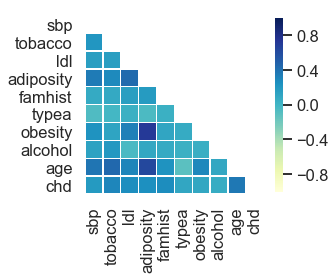

In [75]:
# Generate a mask for the upper triangle
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(4, 4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlations, mask=mask, cmap="YlGnBu", vmin=-1, vmax=1, center=0,
            square=True, linewidths=.2, cbar_kws={"shrink": .8})

plt.yticks()
plt.xticks()

plt.show()

# Save fig
#f.savefig(path+"correlation_vars.pdf", bbox_inches='tight')

# PCA 

In [130]:
pca = PCA() #specifiy n_components=2 to just keep the first 2
pca.fit(X_std)
X_pca = pca.transform(X_std)

pcdf = pd.DataFrame(X_pca, columns=[i for i in range(1,10)])
pcdf_y = pd.concat([pcdf, y], axis=1)
pcdf_y.head()

,1,2,3,4,5,6,7,8,9,chd
0,1.753898,3.056487,1.498334,-0.290557,-0.632938,-0.727661,1.120734,0.610263,0.410402,1
1,0.673305,-0.699290,-0.695697,0.708486,0.022582,0.555710,-0.480413,-1.244019,0.599017,1
2,0.260952,-1.041648,0.060740,-0.946351,-0.858024,-0.472183,-1.338762,-0.402295,-0.251558,0
3,3.176682,0.025958,0.016232,-0.283589,-0.551176,0.450205,-0.105398,0.529818,-0.120475,1
4,1.151703,1.889062,1.802802,-0.412783,0.479137,-0.679640,-0.815270,0.517945,-0.219583,1


## Explore PCA results

### Any visible clusters (PC1 against PC2)?

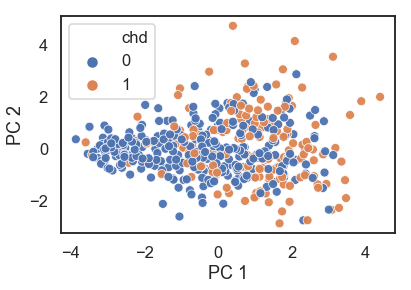

In [135]:
fig = plt.figure()

sns.set_context(context[1])
sns.scatterplot(data=pcdf_y, x=1, y=2, hue='chd', alpha=0.95)
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.legend()
plt.show()

#fig.savefig(path+"2D_pcvisuals.pdf", bbox_inches='tight')

### SCREE PLOT

In [136]:
#define x and y axes 
y_explained = pca.explained_variance_ratio_
y_explained_avg = np.mean(y_explained)
y_explained_cum = np.cumsum(y_explained)
x_pcas = [i for i in range(len(pca.explained_variance_ratio_))]

In [140]:
for i in range(0,len(y_explained_cum)):
    print ('Cumulative explained including ',i+1,'PC' ,y_explained_cum[i])

Cumulative explained including  1 PC 0.3205316111588938
Cumulative explained including  2 PC 0.45354626583559976
Cumulative explained including  3 PC 0.5730742008689552
Cumulative explained including  4 PC 0.6780427503042767
Cumulative explained including  5 PC 0.7709170346266451
Cumulative explained including  6 PC 0.8554299295768769
Cumulative explained including  7 PC 0.9294246207435993
Cumulative explained including  8 PC 0.9805754434752927
Cumulative explained including  9 PC 1.0000000000000002


In [138]:
np.arange(1,10)
labels = ['PC' + str(x) for x in range(1, len(x_pcas)+1)]
print (labels)

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9']


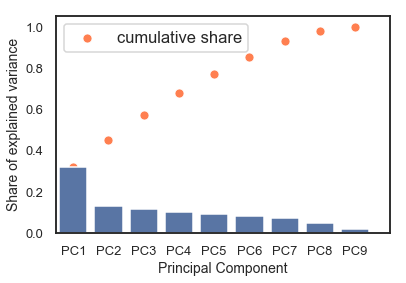

In [139]:
fig = plt.figure()

#sns.lineplot(x=x_pcas, y=y_explained_avg, color='g', markers=True, label='mean explained variance')
sns.scatterplot(x=x_pcas, y=y_explained_cum, color='coral', label="cumulative share")
sns.barplot(x=x_pcas, y=y_explained, color='b')

plt.ylabel('Share of explained variance', fontsize=14)
plt.xlabel('Principal Component', fontsize=14)
plt.xticks(np.arange(0,10), labels, fontsize=13)
plt.yticks(fontsize=13)
plt.legend()

plt.show()

### Which variables are linked to the first 3 PCs? (Correlation Matrix)

In [142]:
pcs = pd.DataFrame(pca.components_)
keys= [i for i in range(10)]
rename_dict = dict(zip(keys,X.columns))
pca_nr = [i for i in range(1,10)]
rename_cols = dict(zip(keys, pca_nr))
pcs = pcs.rename(rename_dict, axis=0)
pcs = pcs.rename(rename_cols, axis=1)
pcs

,1,2,3,4,5,6,7,8,9
sbp,0.323751,0.301834,0.333922,0.516296,0.195143,-0.018322,0.401473,0.121421,0.460081
tobacco,0.238300,0.458509,-0.363914,-0.187617,0.001341,-0.282182,-0.391905,0.543015,0.193043
ldl,-0.125095,0.068152,0.003104,-0.081874,0.338439,0.792293,0.040190,0.459133,-0.135298
adiposity,0.196356,-0.005356,-0.140292,0.135036,-0.833435,0.209846,0.305463,0.258467,-0.157279
famhist,-0.214907,0.623583,0.242225,-0.118895,-0.305396,0.320985,-0.283383,-0.419017,0.199929
typea,0.781375,-0.163107,-0.215291,-0.130867,0.085722,0.331868,-0.173631,-0.379294,0.088748
obesity,0.268070,-0.192862,0.788185,-0.195682,-0.128487,-0.077815,-0.333346,0.276783,-0.145340
alcohol,0.235371,0.488931,0.070334,-0.173134,0.186570,-0.165540,0.338695,-0.125057,-0.691419
age,-0.014142,-0.047787,0.071877,-0.757477,-0.028807,-0.040602,0.504003,0.033094,0.401231


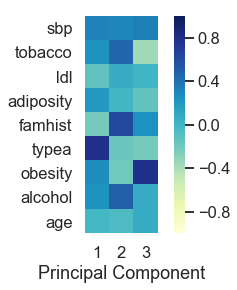

In [143]:
fig = plt.figure()

sns.heatmap(pcs.iloc[:,:3], cmap="YlGnBu", vmin=-1, vmax=1, square=True)
plt.xlabel('Principal Component')
plt.show()

fig.savefig(path+"correlation_matrix.pdf", bbox_inches='tight')

## Appendix code

C:\Users\Philipp\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


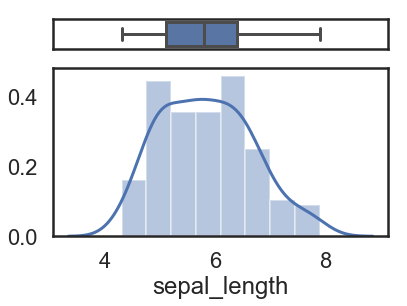

In [111]:
#### Example Boxplot above

# Import library and dataset
import seaborn as sns
import matplotlib.pyplot as plt


df = sns.load_dataset('iris')
 
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(df["sepal_length"], ax=ax_box)
sns.distplot(df["sepal_length"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

plt.show()

C:\Users\Philipp\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


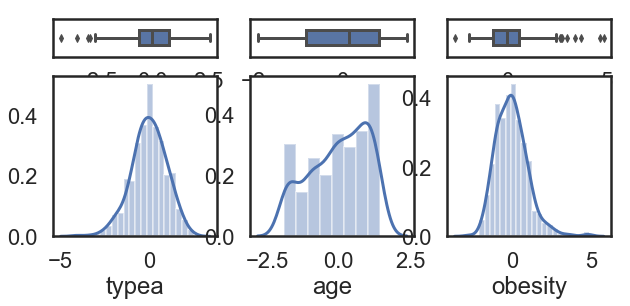

In [112]:
x_cols = ['typea','age','obesity']
fig, axes = plt.subplots(2, 3, figsize=(10, 4), gridspec_kw={"height_ratios": (.20, .85)}) #, sharex=True, sharey=True

counter = 0
for i in range(1):
    for j in range(3):
        sns.boxplot(std[x_cols[counter]], ax=axes[i,j], width=.4)
        sns.distplot(std[x_cols[counter]], ax=axes[i+1,j])
        counter+=1

plt.show()

C:\Users\Philipp\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


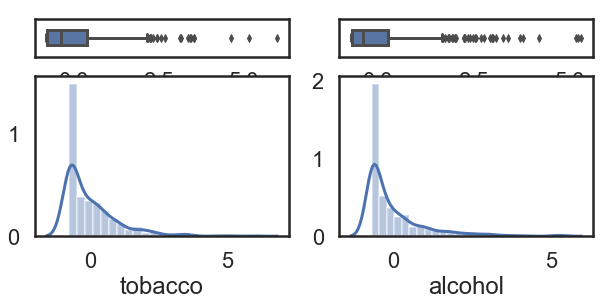

In [113]:
x_cols = ['tobacco', 'alcohol']
xlen = len(x_cols)

fig, axes = plt.subplots(2, xlen, figsize=(10, 4), gridspec_kw={"height_ratios": (.20, .85)}) #, sharex=True, sharey=True

counter = 0
for i in range(1):
    for j in range(xlen):
        sns.boxplot(std[x_cols[counter]], ax=axes[i,j], width=.4)
        sns.distplot(std[x_cols[counter]], ax=axes[i+1,j])
        counter+=1

plt.show()
fig.savefig(path+"box_histograms2.pdf", bbox_inches='tight')